In [7]:
import os
import shutil
import random
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

In [8]:
# --- CONFIGURATION ---
MAX_INSTANCES = 8000  # Cap for majority classes (blobs, cracks, etc.)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def merge_and_analyze(ds1_path, ds2_path, output_path):
    unified_names = [
        'blobs', 'cracks', 'over_extrusion', 'spaghetti', 
        'stringing', 'under_extrusion', 'layer_shift', 'warp'
    ]
    
    ds1_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
    ds2_map = {0: 6, 1: 4, 2: 7}

    # Pre-calculate keep-probability for majority classes to hit MAX_INSTANCES
    # Based on your previous run: blobs(27k), cracks(16k)
    # This logic will be applied during the 'train' split loop.
    
    splits = ['train', 'valid', 'test']
    stats = Counter()

    print("--- Starting Balanced Merge Process ---")

    for split in splits:
        img_out = os.path.join(output_path, split, 'images')
        lbl_out = os.path.join(output_path, split, 'labels')
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lbl_out, exist_ok=True)

        datasets = [(ds1_path, ds1_map, "ds1"), (ds2_path, ds2_map, "ds2")]

        for base_path, mapping, prefix in datasets:
            # Auto-detect 'val' vs 'valid'
            folder_name = split
            if split == 'valid' and not os.path.exists(os.path.join(base_path, split)):
                folder_name = 'val'
            
            img_dir = os.path.join(base_path, folder_name, 'images')
            lbl_dir = os.path.join(base_path, folder_name, 'labels')

            if not os.path.exists(img_dir):
                print(f"Skipping: {img_dir} (not found)")
                continue

            for img_name in os.listdir(img_dir):
                if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                base_name = os.path.splitext(img_name)[0]
                lbl_name = f"{base_name}.txt"
                src_lbl = os.path.join(lbl_dir, lbl_name)
                
                # --- UNDERSAMPLING LOGIC ---
                if split == 'train' and os.path.exists(src_lbl):
                    with open(src_lbl, 'r') as f:
                        lines = f.readlines()
                    
                    classes_in_img = [mapping[int(l.split()[0])] for l in lines if int(l.split()[0]) in mapping]
                    
                    # If image ONLY contains majority classes that are already over the limit
                    # (Simplified: blobs and cracks), we apply a roll to skip them.
                    if all(c in [0, 1] for c in classes_in_img):
                        # Example: blobs (27k) vs target (8k) = ~30% keep rate
                        # If it's a 'blobs' heavy image, we only keep it ~30% of the time
                        if random.random() > 0.35: 
                            continue 
                # ---------------------------

                unique_name = f"{prefix}_{img_name}"
                shutil.copy(os.path.join(img_dir, img_name), os.path.join(img_out, unique_name))

                dst_lbl = os.path.join(lbl_out, os.path.splitext(unique_name)[0] + ".txt")
                if os.path.exists(src_lbl):
                    new_lines = []
                    with open(src_lbl, 'r') as f:
                        for line in f:
                            parts = line.split()
                            if parts and int(parts[0]) in mapping:
                                new_idx = mapping[int(parts[0])]
                                new_lines.append(f"{new_idx} {' '.join(parts[1:])}\n")
                                if split == 'train':
                                    stats[unified_names[new_idx]] += 1
                    
                    with open(dst_lbl, 'w') as f:
                        f.writelines(new_lines)

    # 3. Create data.yaml (Corrected formatting)
    yaml_content = f"train: ../train/images\nval: ../valid/images\ntest: ../test/images\n\nnc: {len(unified_names)}\nnames: {unified_names}"
    with open(os.path.join(output_path, 'data.yaml'), 'w') as f:
        f.write(yaml_content)

    print(f"Successfully merged into: {output_path}")
    visualize_distribution(stats)

def visualize_distribution(stats):
    print("\n--- New Training Class Distribution ---")
    sorted_stats = dict(sorted(stats.items(), key=lambda item: item[1], reverse=True))
    for cls, count in sorted_stats.items():
        print(f"{cls.ljust(20)}: {count} instances")

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_stats.keys(), sorted_stats.values(), color='mediumseagreen', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.title('Balanced Class Distribution (Training Set)')
    plt.ylabel('Instances')
    plt.tight_layout()
    plt.savefig('balanced_distribution.png')
    print("\nBalanced chart saved as 'balanced_distribution.png'")

--- Starting Balanced Merge Process ---
Successfully merged into: merged_3d_printing_dataset

--- New Training Class Distribution ---
blobs               : 9392 instances
over_extrusion      : 7629 instances
stringing           : 7395 instances
spaghetti           : 6696 instances
cracks              : 5964 instances
under_extrusion     : 5910 instances
warp                : 1521 instances
layer_shift         : 744 instances

Balanced chart saved as 'balanced_distribution.png'


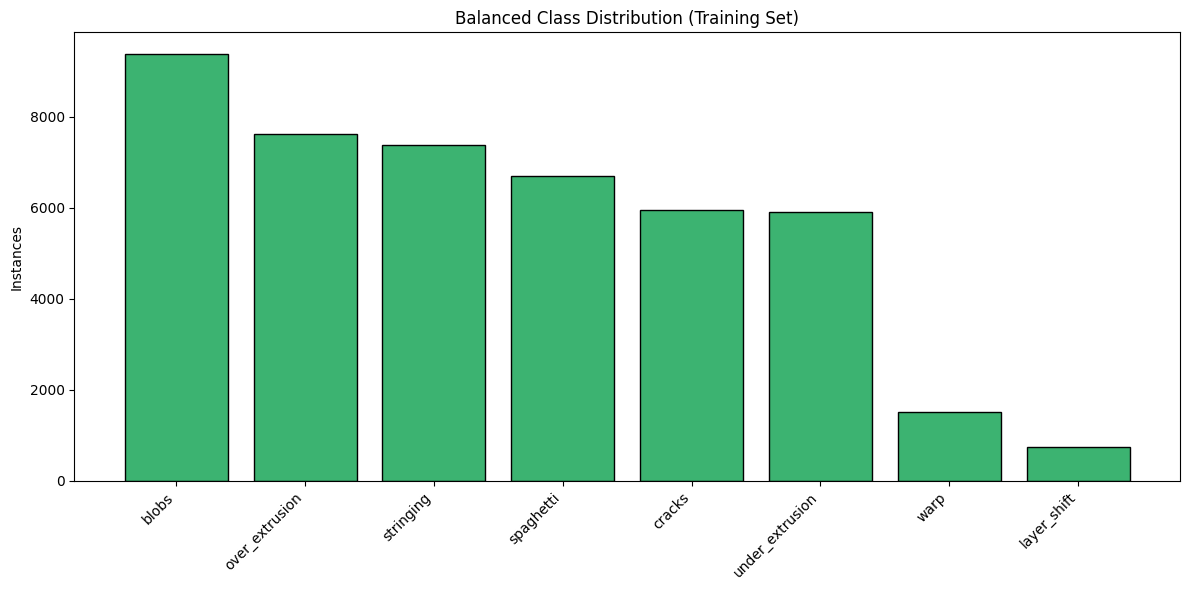

In [9]:
DATASET_1 = "/home/aipc/Desly/Datasets/3d-print Defects"
DATASET_2 = "/home/aipc/Desly/Datasets/FDM_yolo8"
OUTPUT = "merged_3d_printing_dataset"

merge_and_analyze(DATASET_1, DATASET_2, OUTPUT)